In [1]:
import xarray as xr
import importlib
import interpolate_outputs
import os
import numpy as np
from utility_programs.read_routines import SAMI
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from datetime import datetime
import gc
import dask

from tqdm import tqdm

/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
spath = '/glade/scratch/abukowski/simstorm-20110521/GITM-simstorm-run1/sami-gitm-coupled-lores/'

In [3]:
interpolate_outputs = importlib.reload(interpolate_outputs)

In [4]:
d = interpolate_outputs.do_interpolations(spath,
                                            out_path='/glade/scratch/abukowski/postprocessed/',
                                            out_runname='may_storm-on_full_LND',
                                            dtime_sim_start='20110520',
                                            cols=['edens', 
                                                  'o+dens',
                                                  'n+odens',
                                                  'o2+dens',
                                                  'n2+dens',
                                                  'n+dens',
                                                  'odens',
                                                  'nodens',
                                                  'o2dens',
                                                  'ndens',
                                                  'h+vel_parallel',
                                                  'o+vel_parallel',
                                                  'mer_exb',
                                                  'zon_exb',],
                                          
                                            engine='h5netcdf',
                                            # return_ds_too=True,
                                            save_delauney=True,
                                            aarons_mods=True,
                                          sami_mintime = 250,
                                            show_progress=True)

attempting to reuse existing triangulation file


writing Dataset...: : 5250it [6:39:35,  4.57s/it]                                            


In [44]:
d

<xarray.Dataset>
Dimensions:  (time: 625, alt: 82, lat: 360, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-20 ... 2011-05-22T04:00:00
  * alt      (alt) int64 150 175 200 225 250 275 ... 2075 2100 2125 2150 2175
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
Data variables:
    edens    (time, lon, lat, alt) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [ ]:
ds0.edens.isel(time=450, alt=8).plot(x='lon')

In [ ]:
del ds0
ds0 = interpolate_outputs.do_interpolations(spath,
                                            out_path='/glade/scratch/abukowski/postprocessed/',
                                            out_runname='may_storm-on_full_LND_quadres-halved',
                                            dtime_sim_start='20110520',
                                            cols='edens',
                                            engine='h5netcdf',
                                            return_ds_too=True,
                                            save_delauney=False,
                                            coarsen=2,
                                            show_progress=True)

In [ ]:
ds0.edens.isel(time=450, alt=8).plot(x='lon')

In [ ]:
del ds0

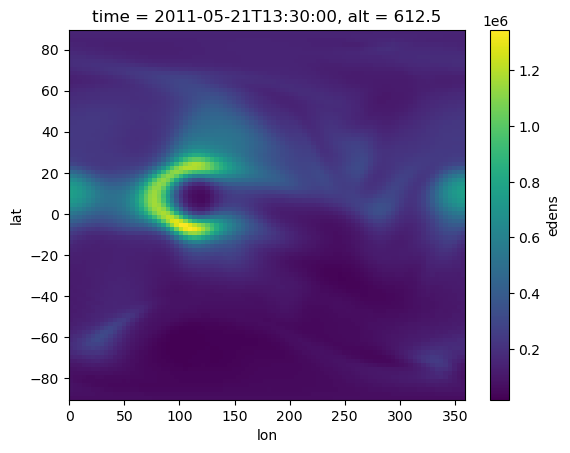

In [9]:
ds0.edens.coarsen(lat=2, lon=4, alt=2).mean().isel(time=450, alt=8).plot(x='lon')

In [10]:
arr = np.arange(0,100,1)

In [11]:
arr[::10]

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

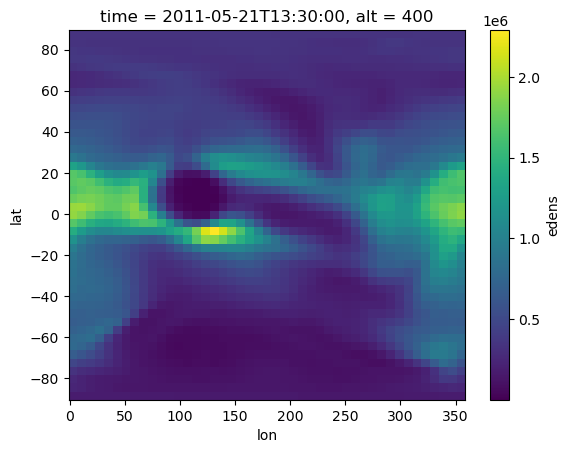

In [9]:
ds0.edens.coarsen(lat=4, lon=4).mean().isel(time=450, alt=8).plot(x='lon')

In [ ]:
ds0.edens.isel(time=450, alt=15).plot(x='lon')

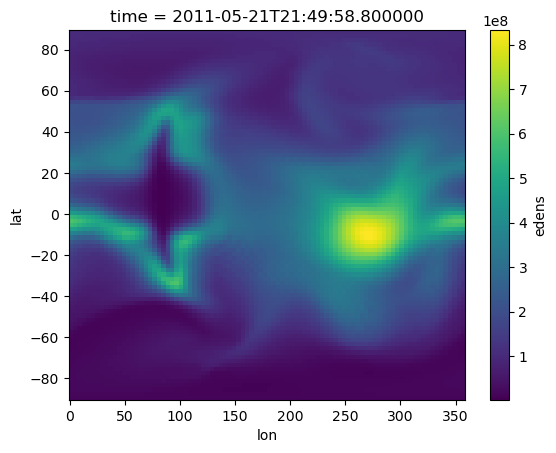

In [12]:
ds0.edens.isel(time=550).coarsen(lat=2, lon=2).mean().integrate('alt').plot(x='lon')

In [7]:
dask.is_dask_collection(ds0)

False

In [2]:
ds1 = xr.open_mfdataset('/glade/scratch/abukowski/postprocessed/may_storm-on_full_LND_doubleres_SAMI_REGRID.nc', engine='h5netcdf')

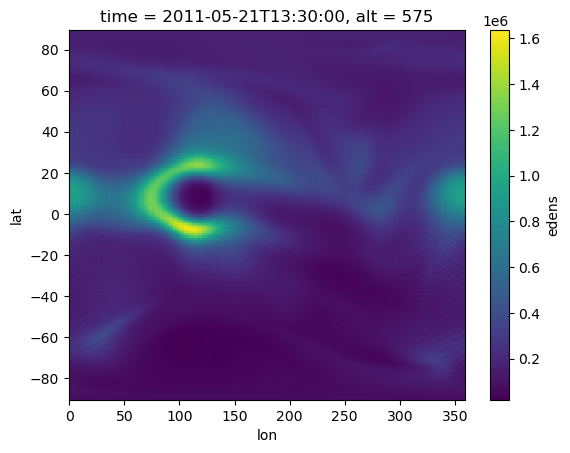

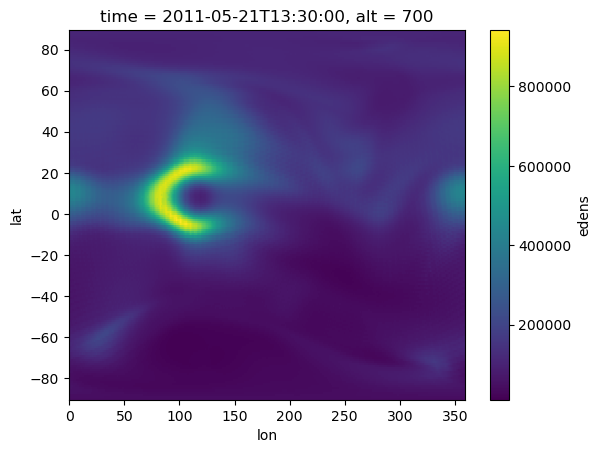

In [3]:
ds1.edens.isel(time=450, alt=15).plot(x='lon')
plt.show()
ds1.edens.isel(time=450, alt=20).plot(x='lon')

In [6]:
plt.figure(figsize=(8,8))
ds1.edens.diff('time', 2).isel(time=570).integrate('alt').coarsen(lat=2, lon=2).mean().plot(x='lon')


KeyboardInterrupt



<Figure size 800x800 with 0 Axes>

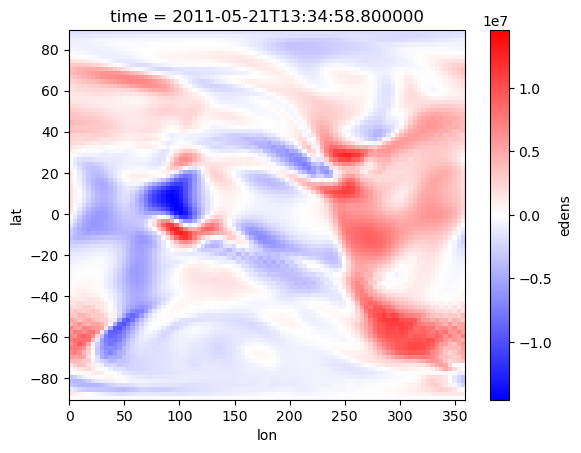

In [8]:
ds1.edens.diff('time').isel(time=450).integrate('alt').coarsen(lat=2, lon=4).mean().plot(x='lon', cmap='bwr')

# Debugging the code...

In [124]:
latout = np.arange(-90, 90, 0.5)
lonout = np.arange(0, 360, 1)
# altout = np.arange(200, 2200, 50)
altout = np.arange(200, 2200, 25)
out_lats, out_lons, out_alts = np.meshgrid(latout, lonout, altout)



In [125]:
out_lon_lat_alt = interpolate_outputs.gps_to_ecef_custom(
    out_lons.flatten(), out_lats.flatten(), out_alts.flatten()).T

In [5]:
data, times = SAMI.read_to_nparray(
                spath, datetime(2011,5,20),
                cols='edens', t_start_idx=10, t_end_idx=15,
                skip_time_check=False)

In [6]:
nz, nf, nlt, nt = SAMI.get_grid_elems_from_parammod(spath)

In [7]:
grid = SAMI.get_sami_grid(spath, nlt, nf, nz)

In [8]:
grid2 = {}
mask = np.where((grid['alt'] > 150) & (grid['alt'] < 2500))
for k in grid.keys():
    grid2[k] = grid[k][mask].flatten()
del grid

In [9]:
in_cart = interpolate_outputs.gps_to_ecef_custom(grid2['glon'],
                            grid2['glat'],
                            grid2['alt']).T

In [41]:
in_cart.shape

(746080, 3)

In [42]:
out_lon_lat_alt.shape

(2592000, 3)

In [43]:
tri = Delaunay(in_cart)

In [44]:
times.shape, data['data']['edens'].shape

((624,), (80, 72, 256, 624))

In [126]:
interpd = []
for t in tqdm(range(15)):
    interp = LinearNDInterpolator(
        tri,
        data['data']['edens'][:, :, :, t][mask].flatten())
    interpd.append(interp(out_lon_lat_alt))


100%|██████████| 15/15 [01:50<00:00,  7.38s/it]


In [127]:
ds = xr.Dataset(coords={
                'time': (['time'], times[:len(interpd)]),
                'alt': (['alt'], altout),
                'lon': (['lon'], lonout),
                'lat': (['lat'], latout)},)
ds['ed'] = (('time', 'lon', 'lat', 'alt'),
                np.array(interpd).reshape(
                    len(interpd),
                len(lonout),
                len(latout),
                len(altout)))

In [128]:
lon = np.linspace(0,360,90)
lat = np.linspace(-90,90,90)
alt= np.arange(250, 2150, 50)

In [169]:
ds2 = ds.coarsen(lat=4, alt=2, lon=8, boundary='pad').mean().interp(lat=lat, lon=lon, alt=alt)

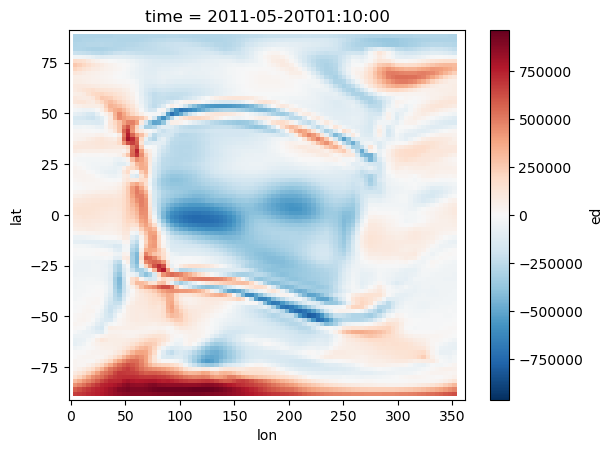

In [173]:
ds2.ed.diff('time', 2).isel(time=-1).integrate('alt').plot(x='lon')

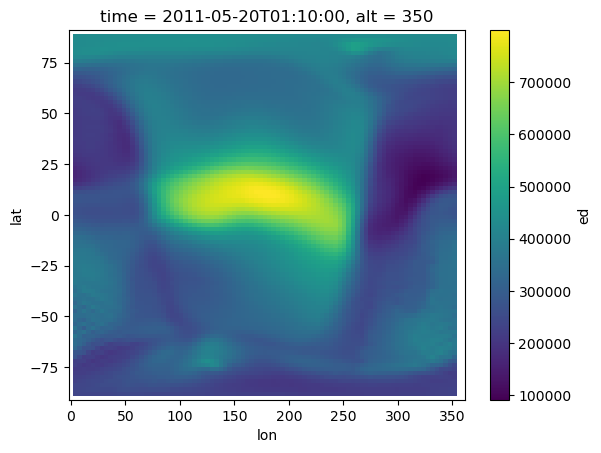

In [171]:
ds2.ed.isel(time=-1, alt=2).plot(x='lon')

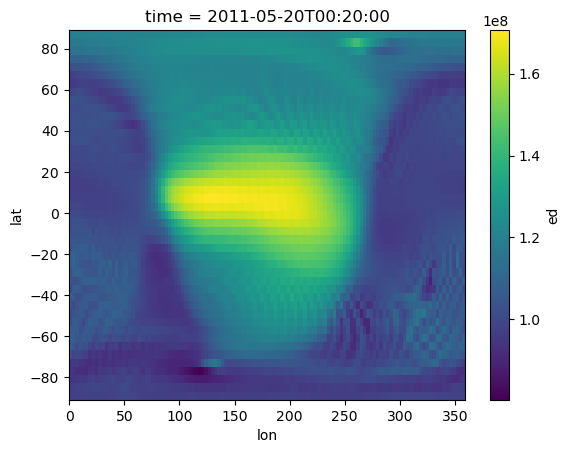

In [52]:
ds.ed.isel(time=4).coarsen(lat=2, lon=3, boundary='pad').mean().integrate('alt').plot(x='lon')

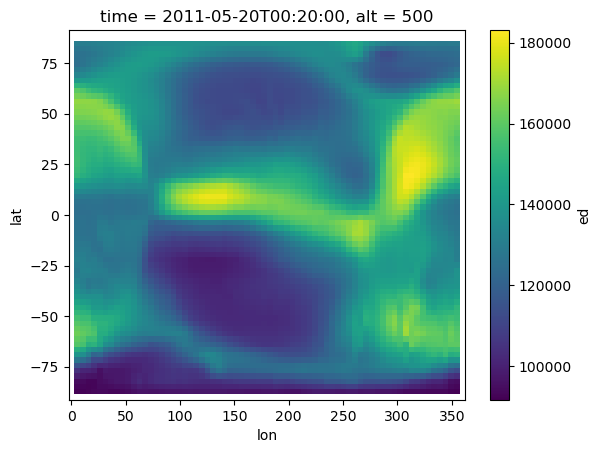

In [29]:
ds.ed.isel(time=4, alt=6).coarsen(lat=3, lon=3).mean().interp(lat=lat, lon=lon, method='linear').plot(x='lon')

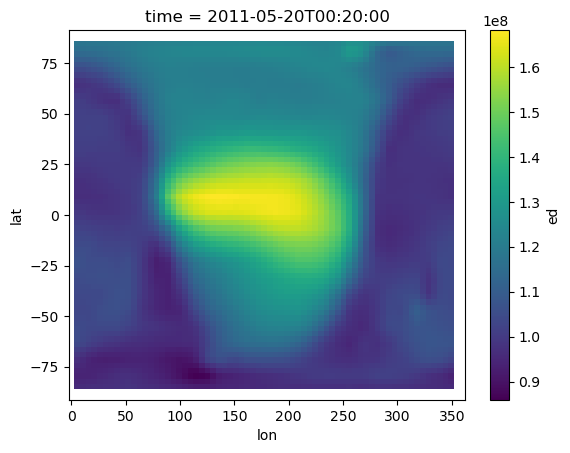

In [36]:
ds.ed.isel(time=4).integrate('alt').coarsen(lat=4, lon=6, boundary='pad').mean().interp(lat=lat, lon=lon).plot(x='lon')

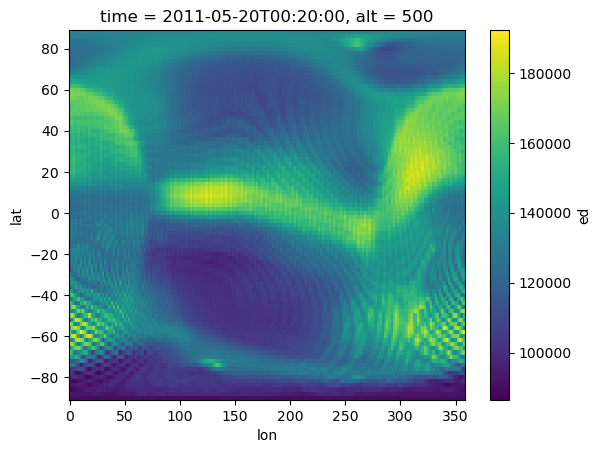

In [24]:
ds.ed.isel(time=4, alt=6).plot(x='lon')

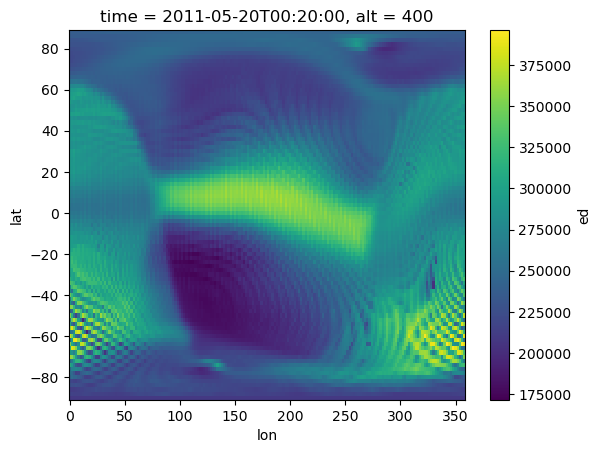

In [25]:
ds.ed.isel(time=4, alt=4).plot(x='lon')

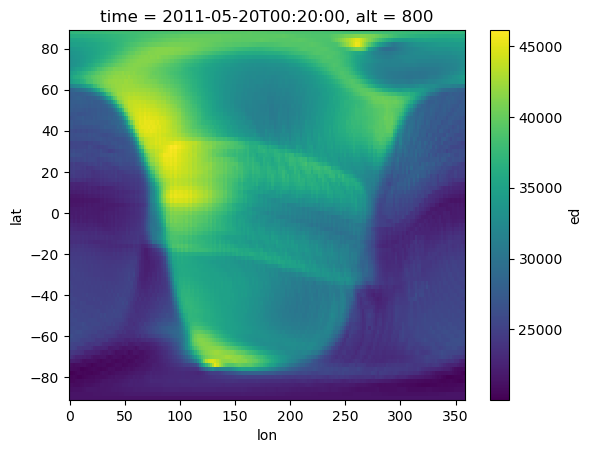

In [26]:
ds.ed.isel(time=4, alt=12).plot(x='lon')

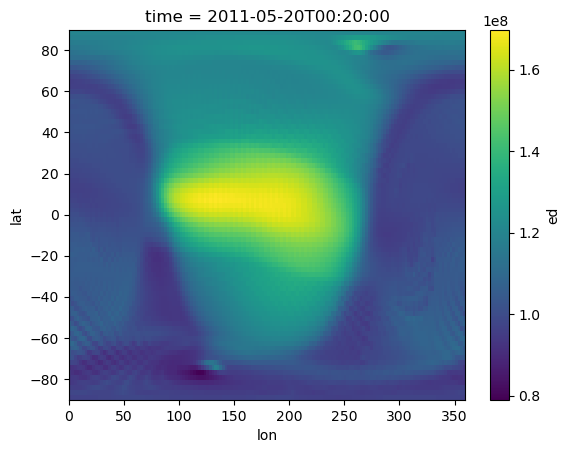

In [65]:
ds.ed.isel(time=4).coarsen(lat=8, lon=8, boundary='pad').mean().integrate('alt').plot(x='lon')

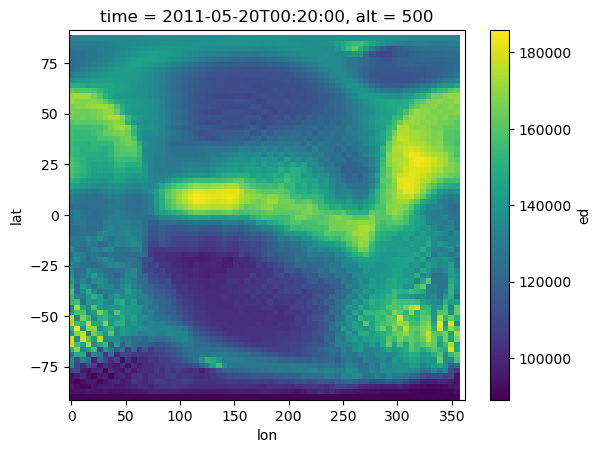

In [60]:
ds.ed.isel(time=4, alt=6).interp(lat=lat, lon=lon, method='linear').plot(x='lon')

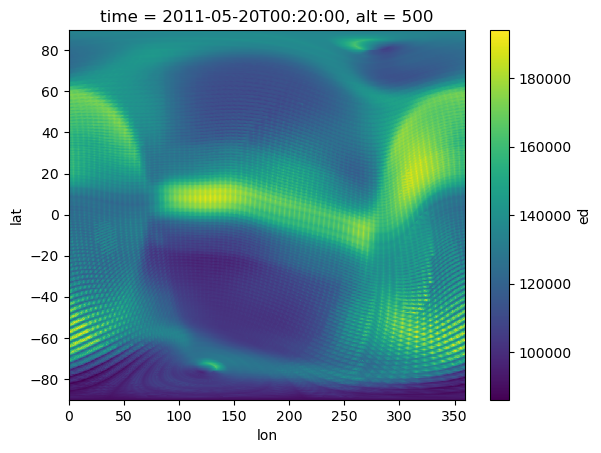

In [61]:
ds.ed.isel(time=4, alt=6).plot(x='lon')

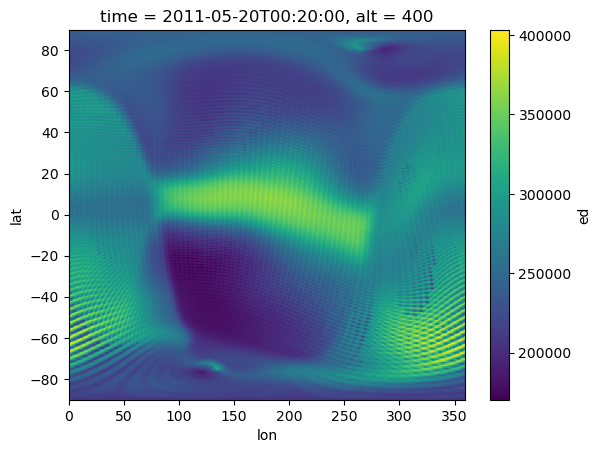

In [62]:
ds.ed.isel(time=4, alt=4).plot(x='lon')

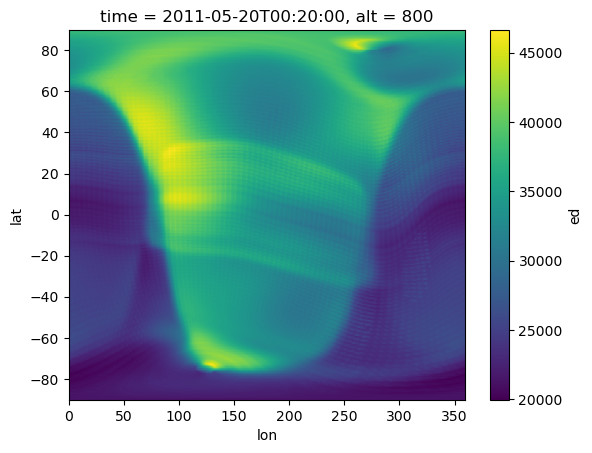

In [63]:
ds.ed.isel(time=4, alt=12).plot(x='lon')

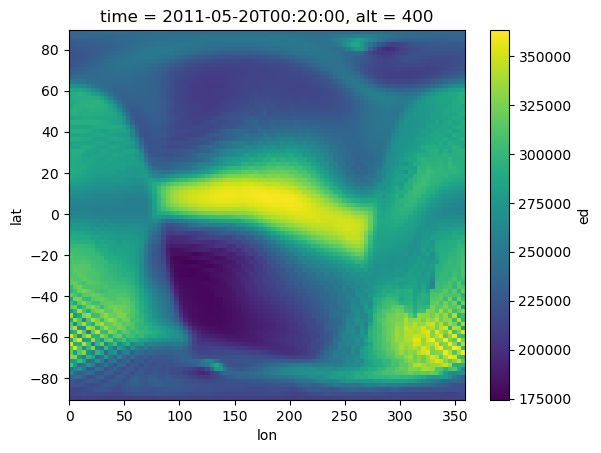

In [31]:
ds.ed.isel(time=4, alt=4).coarsen(lat=2, lon=4, boundary='pad').mean().plot(x='lon')

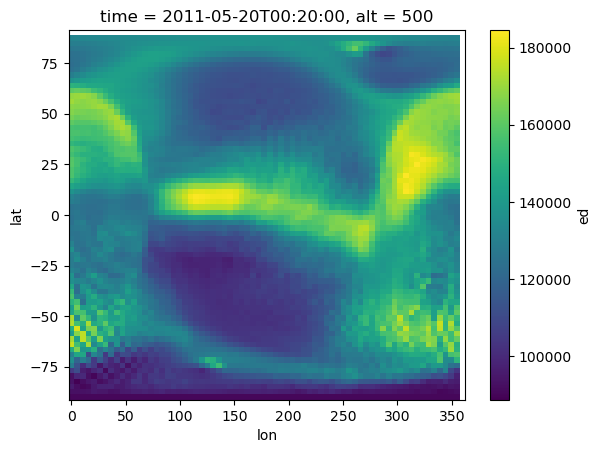

In [44]:
ds.ed.isel(time=4, alt=6).interp(lat=lat, lon=lon, method='linear').plot(x='lon')

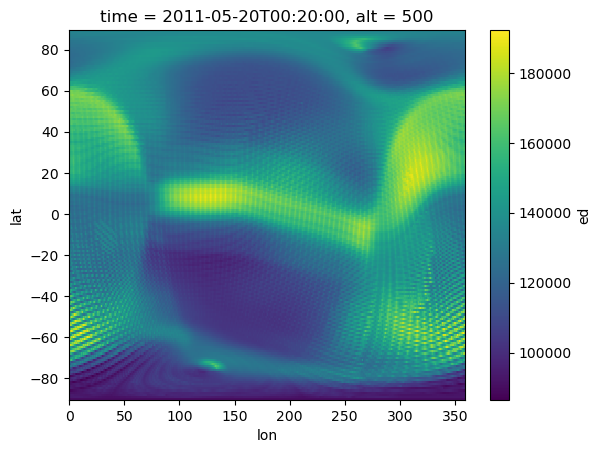

In [45]:
ds.ed.isel(time=4, alt=6).plot(x='lon')

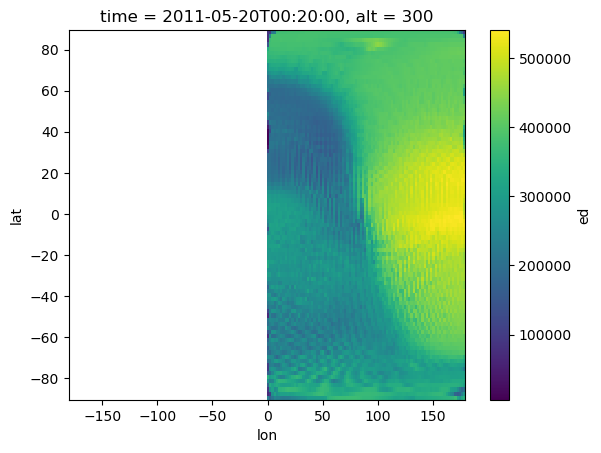

In [66]:
ds.ed.isel(time=4, alt=4).coarsen(lat=2, lon=2).mean().plot(x='lon')

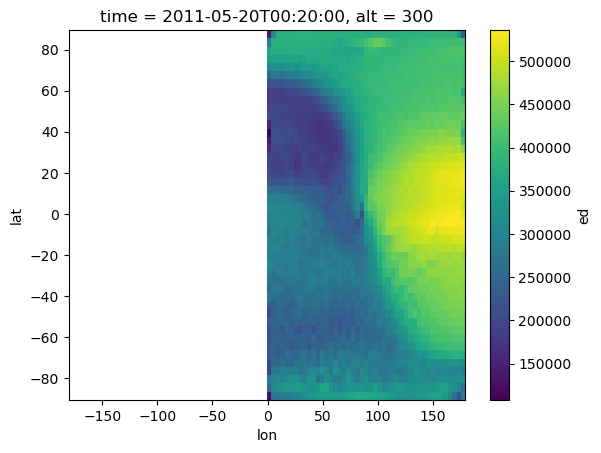

In [29]:
ds.ed.isel(time=4, alt=4).coarsen(lat=4, lon=4).mean().plot(x='lon')

In [76]:
np.min(grid2['glon']), np.max(grid2['glon']), np.min(lonout), np.max(lonout)

(-179.9989013671875, 179.9988555908203, -180, 179)

In [ ]:
tri.coplanar